In [1]:
import sys
sys.path.append("../src")
import numpy as np
import nltk
from nltk.tree import Tree
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from iparse_vq import IParser
import evaluate
import torch
import torch_struct

In [2]:
iparse = IParser("../en_label_gpt2_medium_cat256")
# iparse = IParser("../models/32.pt")

/home/loc/anaconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dev_treebank = iparse.load_dev()

In [4]:
dev_predicted_and_cats, encoded = iparse.parser.parse(
    dev_treebank.without_gold_annotations(),
    subbatch_max_tokens=500,
    tau=0.0,
    return_cats=True,
    return_encoded=True
)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/loc/anaconda3/envs/nlp/lib/python3.11/site-packages/torch/distributions/distribution.py:62: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [5]:
rows = []
dev_trees = []
for i, (tree, cats) in enumerate(dev_predicted_and_cats):
    for (word, p), cat in zip(tree.pos(), cats):
#         p = map_tag('en-ptb', 'universal', p)
        rows.append([p, word.lower(), cat, i])
    dev_trees.append(tree)
pos_df = pd.DataFrame(rows, columns =['POS', 'Word', 'Tag', 'Sentence'])


In [6]:
used_tags = np.unique(pos_df['Tag'])

print('unused tags')
[i for i in range(iparse.parser.d_cats) if i not in used_tags]

unused tags


[18]

In [7]:
def search_tag(tag):
    return pos_df[pos_df['Tag'] == tag]

In [8]:
def search_word(word):
    return pos_df[pos_df['Word'] == word.lower()].groupby(['POS', 'Tag'], as_index=False).count().sort_values(['POS', 'Tag'])

In [9]:
search_tag(31).sample(15)

,POS,Word,Tag,Sentence
14039,",",",",31,637
3935,",",",",31,183
28424,",",",",31,1310
30407,",",",",31,1399
22082,",",",",31,1003
12999,",",",",31,592
27612,",",",",31,1269
23528,",",",",31,1073
2763,",",",",31,127
14193,",",",",31,644


Federal Express , Dow Chemical , Ford and National City Corp. will buy the home or let the worker sell to an outside firm , but usually wo n't cover a loss .


/home/loc/anaconda3/envs/nlp/lib/python3.11/site-packages/torch/distributions/distribution.py:62: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


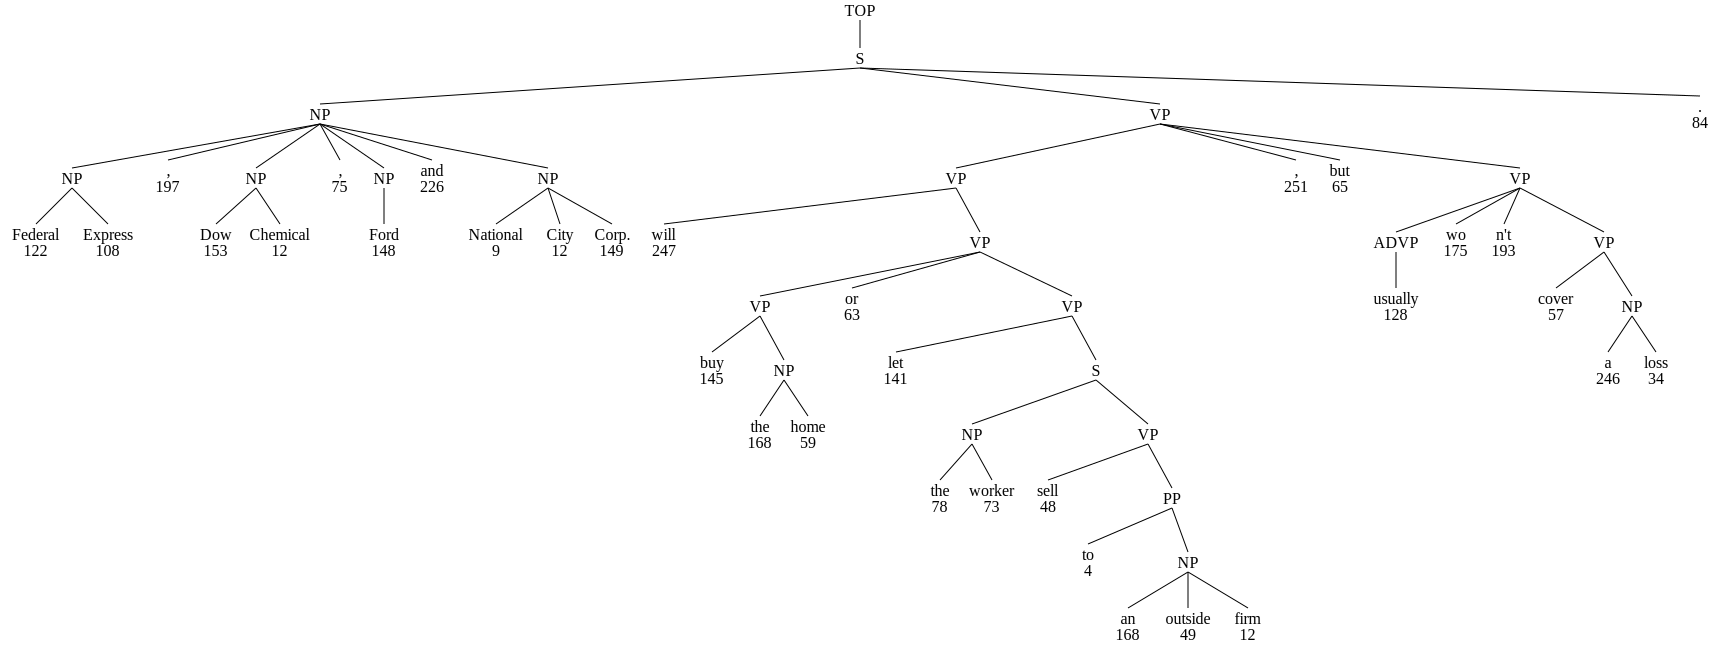

In [10]:
st = ' '.join(dev_predicted_and_cats[471][0].leaves())
print(st)
t, c = iparse.parse_sentence(st)
t

In [11]:
c

[122,
 108,
 197,
 153,
 12,
 75,
 148,
 226,
 9,
 12,
 149,
 247,
 145,
 168,
 59,
 63,
 141,
 78,
 73,
 48,
 4,
 168,
 49,
 12,
 251,
 65,
 128,
 175,
 193,
 57,
 246,
 34,
 84]

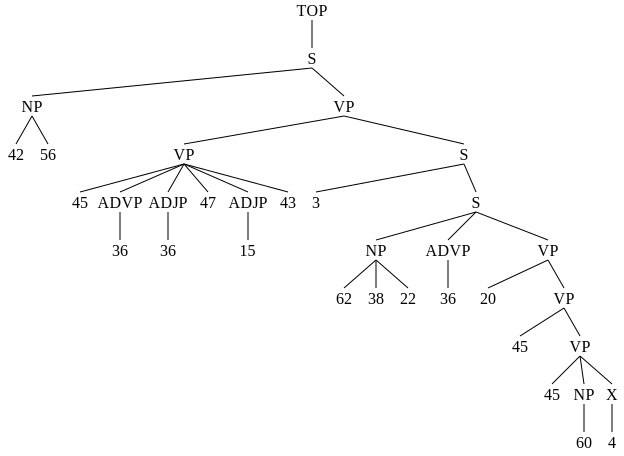

In [12]:
iparse.tree_from_cats([42, 56, 45, 36, 36, 47, 15, 43, 3, 62, 38, 22, 36, 20, 45, 45, 60, 4])

In [13]:
def replace_leaves(tree, dummy='X'):
    leaf_treepositions = tree.treepositions('leaves')
    for i, leaf_treeposition in enumerate(leaf_treepositions):
        tree[leaf_treeposition] = dummy

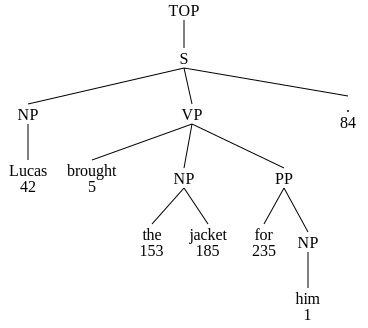

In [14]:
t, c = iparse.parse_sentence("Lucas brought the jacket for him .")
t

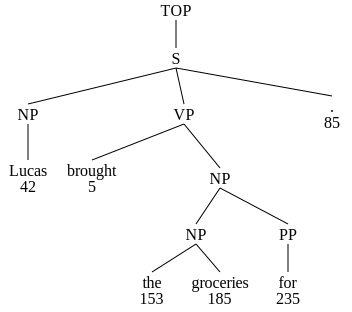

In [15]:
t, c = iparse.parse_sentence("Lucas brought the groceries for  .")
t

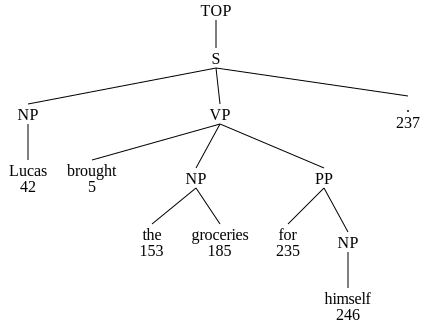

In [16]:
t, c = iparse.parse_sentence("Lucas brought the groceries for himself .")
t

In [17]:
def relabel_tree(sentence, labels):
    t, c = iparse.parse_sentence(sentence)
    assert len(labels) == len(c), 'mismatch between length of labels and tokens'
    for i, leafPos in enumerate(t.treepositions('leaves')):
        t[leafPos] = t[leafPos] + '\t\n' + str(labels[i])
    return t
    
    

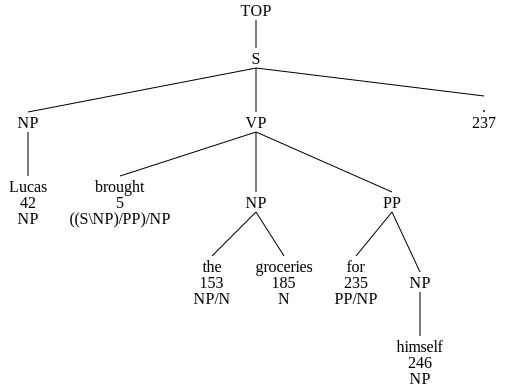

In [18]:
relabel_tree('Lucas brought the groceries for himself .', ['NP', '((S\\NP)/PP)/NP', 'NP/N', 'N', 'PP/NP', 'NP', ''])


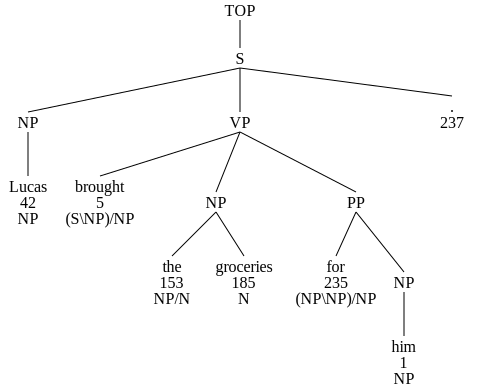

In [19]:
relabel_tree('Lucas brought the groceries for him .', ['NP', '(S\\NP)/NP', 'NP/N', 'N', '(NP\\NP)/NP', 'NP', ''])


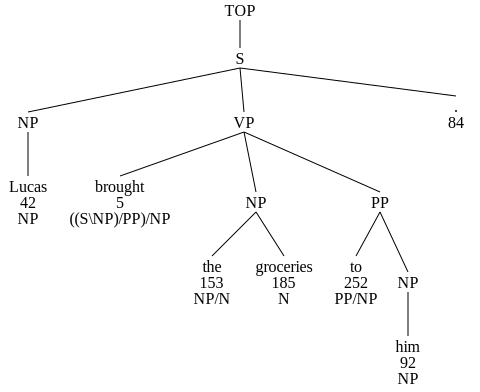

In [20]:
relabel_tree('Lucas brought the groceries to him .', ['NP', '((S\\NP)/PP)/NP', 'NP/N', 'N', 'PP/NP', 'NP', ''])

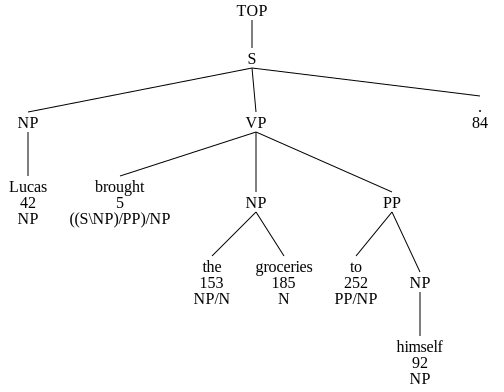

In [21]:
relabel_tree('Lucas brought the groceries to himself .', ['NP', '((S\\NP)/PP)/NP', 'NP/N', 'N', 'PP/NP', 'NP', ''])



In [22]:
c

[42, 5, 153, 185, 235, 246, 237]

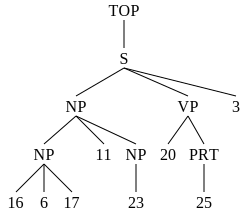

In [23]:
iparse.tree_from_cats([16, 6, 17, 11, 23, 20, 25, 3])

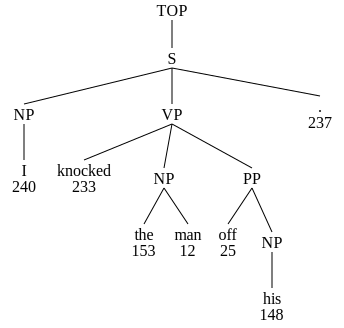

In [24]:
t, c = iparse.parse_sentence("I knocked the man off his .")
t

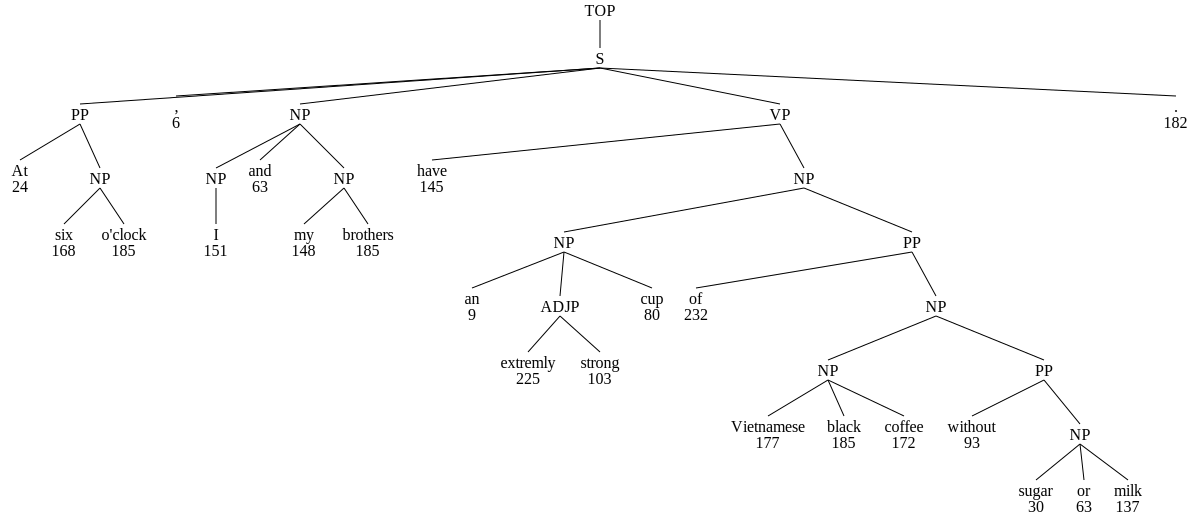

In [25]:
t, c = iparse.parse_sentence("At six o'clock , I and my brothers have an extremly strong cup of Vietnamese black coffee without sugar or milk .")
t

In [29]:
type(t)

nltk.tree.tree.Tree

In [28]:
print(str(t))

(TOP
  (S
    (PP At
 24 (NP six
 168 o'clock
 185))
    ,
 6
    (NP (NP I
 151) and
 63 (NP my
 148 brothers
 185))
    (VP
      have
 145
      (NP
        (NP an
 9 (ADJP extremly
 225 strong
 103) cup
 80)
        (PP
          of
 232
          (NP
            (NP Vietnamese
 177 black
 185 coffee
 172)
            (PP without
 93 (NP sugar
 30 or
 63 milk
 137))))))
    .
 182))


In [ ]:
evalb_dir="../EVALB_labeled/"
dev_fscore = evaluate.evalb(
    evalb_dir, dev_treebank.trees, dev_trees)
print(dev_fscore)

AssertionError: 

In [ ]:
t.draw()

In [ ]:
t.pretty_print()

                                                              TOP                                                                                 
                                                               |                                                                                   
                                                               S                                                                                  
  _____________________________________________________________|_________                                                                          
 |   |        |                    |                                     VP                                                                       
 |   |        |                    |                       ______________|__________________________                                               
 |   |        |                    |                      |                                         NP             

In [ ]:
type(t)

nltk.tree.tree.Tree

In [ ]:
import matplotlib.pyplot as plt

# Draw and save as image
t.draw()

In [ ]:
c

[24,
 168,
 185,
 6,
 151,
 63,
 148,
 185,
 145,
 9,
 225,
 103,
 80,
 232,
 177,
 185,
 172,
 93,
 30,
 63,
 137,
 182]

In [ ]:
from nltk.tree import Tree

def load_and_show_trees(file_path, num_samples=1):
    trees = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                trees.append(Tree.fromstring(line))
    
    print(f"Đã load {len(trees)} cây.\n")
    
    # Hiển thị vài cây mẫu
    for i, t in enumerate(trees[:num_samples]):
        print(f"--- Cây mẫu #{i+1} ---")
        print(t.pformat(margin=60)) 
        t.pretty_print() 
        print("\n")
    
    return trees

# Sử dụng hàm
trees = load_and_show_trees('../data/23.auto.clean')

Đã load thành công 2416 cây.

--- Cây mẫu #1 ---
(TOP
  (S
    (INTJ (RB No))
    (, ,)
    (NP (PRP it))
    (VP (VBD was) (RB n't) (NP (NNP Black) (NNP Monday)))
    (. .)))
             TOP                         
              |                           
              S                          
  ____________|________________________   
 |    |   |       VP                   | 
 |    |   |    ___|_________           |  
INTJ  |   NP  |   |         NP         | 
 |    |   |   |   |     ____|____      |  
 RB   ,  PRP VBD  RB  NNP       NNP    . 
 |    |   |   |   |    |         |     |  
 No   ,   it was n't Black     Monday  . 



